<a href="https://colab.research.google.com/github/Rhino-byte/Skimit_NLP/blob/main/nlp_skimit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project : SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to GPU


In [ ]:
!nvidia -smi -L

/bin/bash: line 1: nvidia: command not found


## Get the data

Since we'll be replicating the paper above (Published 200k RCT), Let's download the dataset they used.

We cando so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed 20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our expperiments using 20k dataset with numbers replaced by @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Check all of the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

In [ ]:
'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt'== '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'


False

## Preprocess data

Now we've got some text data, it's time to become one with it and one of the best ways to become one with the data is to ...

`Visualize, visualize, visualize`

So with that in mind, let's write a function to read in all of the lines of a target text file



In [ ]:
 # Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of a text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()



In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"/train.txt")# read lines with the training files
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best reprsented as a list of dictionaries...

```
[{ 'line_number': 0
   'target': 'BACKGROUND',
   'text': ' Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines': 11},
   ......]

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it content and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all line from filename
  abstract_lines = "" # Create an empty abstract
  abstract_sample = [] # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Check to see if their is an ID line
      abstract_id =line
      abstract_lines = "" # reset the abstract string if line is a new line
    elif line.isspace(): # Check to see if it is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines(\n)

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstract_line_number # what no line does the line appear in the abstract?
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["total_lines"] = len(abstract_line_split)-1 # How many total lines are there in the target abstracts
        abstract_sample.append(line_data) # Add line data to abstract sample list

    else: # If the above condition aren't fullfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_sample






In [ ]:
# @title How `isspace()` works

# @markdown In Python, whitespace refers to any character that represents horizontal or vertical space, including spaces, tabs, newlines, and carriage returns. Unlike many other languages where it is mostly ignored, whitespace is syntactically significant in Python, especially for indicating code structure through indentation.

text_list =[ "\n", '\t', ' ']

x = [txt.isspace() for txt in text_list]
print(x)

[True, True, True]


In [ ]:
# @title How `splitlines()` works

# @markdown The `splitlines()` method splits a string into a list. The splitting is done at line breaks.
txt = "Thank you for the music\nWelcome to the jungle"

x = txt.splitlines()

print(x)

['Thank you for the music', 'Welcome to the jungle']


In [ ]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'/train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'/dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'/test.txt')
print(len(train_samples),len(val_samples),len(test_samples))


180040 30212 30135
CPU times: user 524 ms, sys: 111 ms, total: 636 ms
Wall time: 754 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

## Explolatory Data Analysis

The `preprocess_text_with_line_numbers()` function worked great
How about we turn our list of dictionaries into pandas Dataframe's so we visualize them better?

In [ ]:
import pandas as pd
train_df =pd.DataFrame(train_samples)
val_df =pd.DataFrame(val_samples)
test_df =pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


looks like sentences with the `OBJECTIVE` label are the least common.



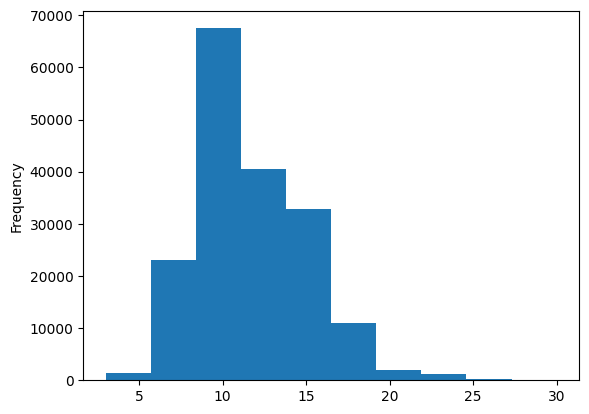

In [ ]:
# How about we check the distribution of our abstract lengths?
train_df.total_lines.plot.hist();

Most of the abstracts are around 7 to 15 sentences in length.


### Get list of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our  `"text"`

In [ ]:
train_sentences =train_df["text"].tolist()
val_sentences =val_df["text"].tolist()
test_sentences =test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [ ]:
import tensorflow as tf


In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
# Check how the one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded =label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded =label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded =label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from labelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names,num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

## Model 0: Getting a baseline model

We will be using a bayesian model to try and classify the abstracts

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ('tfidf',TfidfVectorizer()), # Convert words to numbers using tfidf
    ('clf',MultinomialNB()) # Model the text
])

model_0.fit(train_sentences,train_labels_encoded)

In [ ]:
# Evaluate our baseline model
baseline_score =model_0.score(val_sentences,val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.18%


Our base_line model has an accuracy of 72.1% accuracy this will be the number to beat with our deeper models.

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# We will implement the use of sklearn
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def score_function(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model precision recall and f1-score
  pre,rec,f1,_= list(precision_recall_fscore_support(y_true=y_true,y_pred= y_pred,average='weighted'))
  # Calculate model accuracy
  acc= accuracy_score(y_true=y_true,y_pred= y_pred)

  data= {'Accuracy_score': acc , 'F1-Score': f1,'Recall_Score':rec, 'Precision_Score': pre }
  return(data)

In [ ]:
bayesian_model_score = score_function(y_pred=baseline_preds,y_true=val_labels_encoded)
bayesian_model_score

{'Accuracy_score': 0.7218323844829869,
 'F1-Score': 0.6989250353450294,
 'Recall_Score': 0.7218323844829869,
 'Precision_Score': 0.7186466952323352}

## Prepairing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization


In [ ]:
# How long is each sentences on average
sent_lens =[len(sentence.split()) for sentence in train_sentences]
avg_sent_len =np.mean(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

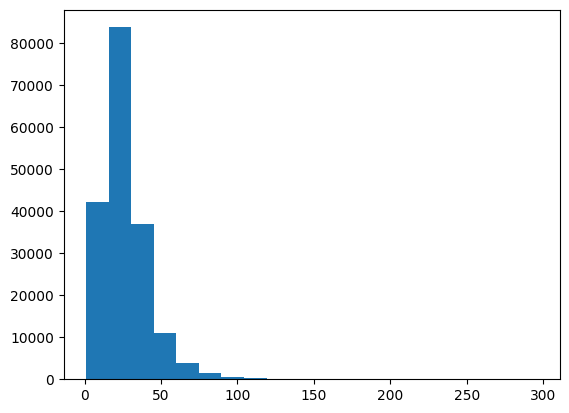

In [ ]:
# What's the distribution look like for the length of sentences
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [ ]:
# How long of a sentence length covers 95% of the data example

output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
# Maximum sequence length in training set
max(sent_lens)


296

### Create text Vectorizarion layer

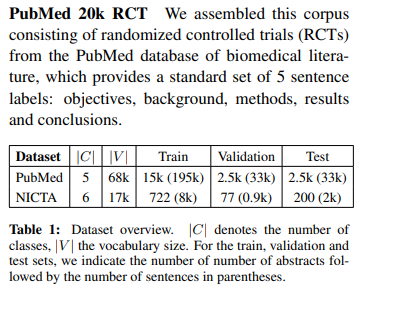

In [ ]:
max_vocab_length = 68000 # Based on the paper
max_length = 55 # Covers 95% of the sentences length
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length =max_length
                                    )

In [ ]:
# Adapt the textVectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# How many words are in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)

64841

In [ ]:
# Test our text vectorizer on random sentences
import random
target_sentence =random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer(target_sentence)}")


Text:
the beneficial effects of fish and n-@ polyunsaturated fatty acids ( pufas ) consumption on atherosclerosis have been reported in numerous epidemiological studies .

Length of text:24

Vectorized text:[   2  748   71    4 2025    3   40 4571 1105 1458 5971  419   18 2813
   99  167  205    5 5060 4492  202    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# Create an embedding layer
embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim = 128,
                             mask_zero =True, #
                             name = "Embedding_layer"
                              )



In [ ]:
# embedding.input_dim
len(rct_20k_text_vocab)

64841

In [ ]:

# Embed the random sentence on our text vectorizer
target_sentence =random.choice(train_sentences)
target_vectorize = text_vectorizer(target_sentence)
print(f'Text_vectorized:\n{target_vectorize}')
print(f'\nShape:{target_vectorize.shape}')
sample_embed = embedding(target_vectorize)
sample_embed

Text_vectorized:
[    5     8 11849  7773   558     7  2630   585  1610     2   257     4
   511  1544     5  9596     2   282     4   673  1529   150     6  6362
  1544     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]

Shape:(55,)


<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[-0.00423328,  0.00023187,  0.02622887, ...,  0.0266193 ,
        -0.0283432 ,  0.01886966],
       [ 0.01169677,  0.02910669,  0.02886441, ...,  0.02622254,
         0.0204022 , -0.04685619],
       [-0.02569488,  0.02943398, -0.00715904, ..., -0.00995065,
        -0.00424544, -0.03756902],
       ...,
       [ 0.02775382,  0.03850562, -0.03482137, ..., -0.03678564,
         0.04402721, -0.04975784],
       [ 0.02775382,  0.03850562, -0.03482137, ..., -0.03678564,
         0.04402721, -0.04975784],
       [ 0.02775382,  0.03850562, -0.03482137, ..., -0.03678564,
         0.04402721, -0.04975784]], dtype=float32)>

### Create datasets

We're going to create our dataset with `tf.data` API which provides methods which enable faster data loading.

> 📖**Resources:** For best practises on data loading in Tensorflow, check out the following:

* [tf.data.Build Tesnorflow input pipelines](https://www.tensorflow.org/guide/data)
* [Better perfomance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

We need to create a batched `PrefetchDataset` we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTONE` will also Tensorflow to determine the optimal amount of compute to use to prepare datasets.


In [ ]:
# Turns our data into Tensorflow  Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the Tensorslices  Dataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [107]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

## Model 1: Conv1D with token embeddings
All of our deep learning models will follow a similar structure

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

```

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

* Build model
* Train model
* Evaluate model (make predictions and compare to ground truth)

In [ ]:
# Create ID convolutional model to process sequences
inputs = layers.Input(shape=(1,),dtype= tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embedding = embedding(text_vectors) # Create embeddings
x = layers.Conv1D(64,kernel_size=5,padding='same',activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile model
model_1.compile(loss = 'categorical_crossentropy', # If your labels are interger form (not one hot) use sparse_categorical_crossentropy
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_layer (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model on the data
model_1_history = model_1.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5237 - loss: 1.1575 - val_accuracy: 0.7414 - val_loss: 0.6971
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7421 - loss: 0.6891 - val_accuracy: 0.7686 - val_loss: 0.6390
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7673 - loss: 0.6295 - val_accuracy: 0.7852 - val_loss: 0.6078


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7839 - loss: 0.6058


[0.6080015897750854, 0.7828677296638489]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[3.16083491e-01, 7.63291866e-02, 2.57842481e-01, 3.14432174e-01,
        3.53127606e-02],
       [2.00488348e-03, 1.37923914e-03, 9.57718790e-01, 2.52237706e-03,
        3.63748223e-02],
       [6.17682643e-04, 2.10911781e-03, 8.46529186e-01, 3.75425647e-04,
        1.50368661e-01],
       ...,
       [1.78352674e-03, 4.08719368e-02, 3.20892893e-02, 1.04733603e-03,
        9.24207866e-01],
       [7.54871452e-03, 4.34124768e-02, 8.53131488e-02, 3.72516434e-03,
        8.60000491e-01],
       [1.06685217e-02, 4.81222004e-01, 6.60744980e-02, 1.12973405e-02,
        4.30737674e-01]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds =tf.argmax(model_1_pred_probs,axis =1)
model_1_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [ ]:
model_1_results = score_function(y_true =test_labels_encoded,y_pred=model_1_preds)
model_1_results

{'Accuracy_score': 0.7774680603948897,
 'F1-Score': 0.7749056640925897,
 'Recall_Score': 0.7774680603948897,
 'Precision_Score': 0.7743390126500306}

In [ ]:
bayesian_model_score

{'Accuracy_score': 0.7218323844829869,
 'F1-Score': 0.6989250353450294,
 'Recall_Score': 0.7218323844829869,
 'Precision_Score': 0.7186466952323352}

## Tensorflow Hub Pretrained Feature extractor

More on the how to load keras models using kaggle:https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using tensorflow hub's universal sentence encoder


In [ ]:
import tensorflow_hub as hub
encoder = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

# Pass In our sample sentences
random_sentence = random.choice(train_sentences)
print(random_sentence)
embedded_sample =encoder([random_sentence])


furthermore , the use of pedometers is promising to enhance physical activity during the entire day and targets a wide range of adolescents regarding fitness and weight .


In [ ]:
embedded_sample.shape

TensorShape([1, 512])

In [ ]:
%%time

from tqdm.auto import tqdm
tqdm.pandas()
# Precompute Embeddings
tf.random.set_seed(42)
def embedded_sentence(sentences,batch_size=32):
  embeddings = []
  for i in tqdm(range(0,len(sentences)+1,batch_size)):
    batch = sentences[i:i+batch_size]
    emb = encoder(batch)
    embeddings.append(emb.numpy())
  return np.vstack(embeddings).astype(np.float32)


# Train, Validate and Test data embeddings
emb_train_set = embedded_sentence(train_sentences)
emb_valid_set = embedded_sentence(val_sentences)
emb_test_set =embedded_sentence(test_sentences)



In [ ]:
emb_train_set.shape,emb_valid_set.shape,emb_test_set.shape,

((180040, 512), (30212, 512), (30135, 512))

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((emb_train_set,train_labels_one_hot))
valid_set = tf.data.Dataset.from_tensor_slices((emb_valid_set,val_labels_one_hot))
test_set = tf.data.Dataset.from_tensor_slices((emb_test_set,test_labels_one_hot))



In [ ]:
train_set = train_set.batch(32).prefetch(tf.data.AUTOTUNE)
valid_set = valid_set.batch(32).prefetch(tf.data.AUTOTUNE)
test_set = test_set.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Add a dimension to the dataset
def add_dimension(feature,label):
  expand_features = tf.expand_dims(feature,axis=1)
  return expand_features,label

# Map to the datasets feature
train_set = train_set.map(add_dimension)
valid_set = valid_set.map(add_dimension)
test_set = test_set.map(add_dimension)


In [ ]:
train_set.element_spec

(TensorSpec(shape=(None, 1, 512), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

### Assignment : Build a CNN model and RNN (lstm, GRU)

#### CNN



In [ ]:

inputs = layers.Input(shape=(1,512),dtype=tf.float32)
x = layers.Conv1D(64,kernel_size=4,padding='same',activation='relu')(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,461 (513.52 KB)

 Trainable params: 131,461 (513.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2_history =model_2.fit(train_set,
            # steps_per_epoch = int(0.1*len(train_set)),
            epochs = 3,
            validation_data = valid_set)
            # validation_steps = int(.1*len(valid_set)))

Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6805 - loss: 0.8379 - val_accuracy: 0.7382 - val_loss: 0.6854
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7422 - loss: 0.6774 - val_accuracy: 0.7535 - val_loss: 0.6464
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7583 - loss: 0.6383 - val_accuracy: 0.7592 - val_loss: 0.6287


In [ ]:
# Evaluate model on  test data
model_2.evaluate(test_set)

942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7512 - loss: 0.6496


[0.6472804546356201, 0.7542392611503601]

In [ ]:
# Predict on the unseen data
cnn_pred_prob = model_2.predict(test_set)

# Convert the pred probabilites to get the classes
cnn_pred = tf.argmax(cnn_pred_prob,axis=1)
cnn_pred

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([4, 2, 2, ..., 4, 4, 1])>

In [ ]:
cnn_score =score_function(y_pred=cnn_pred,y_true=test_labels_encoded)
cnn_score

{'Accuracy_score': 0.7542392566782811,
 'F1-Score': 0.7494050723268696,
 'Recall_Score': 0.7542392566782811,
 'Precision_Score': 0.75001306451673}

#### LSTM



In [ ]:

inputs = layers.Input(shape=(1,512),dtype = tf.float32)
x = layers.LSTM(64,activation='relu')(inputs)
outputs = layers.Dense(num_classes,activation='softmax')(x)

model_3 =tf.keras.Model(inputs,outputs)

# Compile model
model_3.compile(loss = 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,037 (578.27 KB)

 Trainable params: 148,037 (578.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3_history = model_3.fit(train_set,
                              epochs = 3,
                              validation_data =valid_set
                              )

Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6664 - loss: 0.8621 - val_accuracy: 0.7378 - val_loss: 0.6871
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7421 - loss: 0.6782 - val_accuracy: 0.7531 - val_loss: 0.6462
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7570 - loss: 0.6402 - val_accuracy: 0.7624 - val_loss: 0.6271


In [ ]:
# Evaluate on the test data
model_3.evaluate(test_set)

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7520 - loss: 0.6448


[0.6444985270500183, 0.7531442046165466]

In [ ]:
## Predict on the test data
lstm_prob_pred =model_3.predict(test_set)

lstm_pred = tf.argmax(lstm_prob_pred,axis=1)
lstm_pred

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [ ]:
# Get the model score's
lstm_score = score_function(test_labels_encoded,lstm_pred)
lstm_score

{'Accuracy_score': 0.7531441845030695,
 'F1-Score': 0.748254531828689,
 'Recall_Score': 0.7531441845030695,
 'Precision_Score': 0.7483628965386807}

#### GRU

In [ ]:
inputs = layers.Input(shape =(1,512),dtype= tf.float32)
x = layers.GRU(64)(inputs)
outputs = layers.Dense(num_classes,activation = 'softmax')(x)
model_4 = tf.keras.Model(inputs,outputs)
# Compile model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,301 (434.77 KB)

 Trainable params: 111,301 (434.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_4_history = model_4.fit(train_set,
                              epochs = 3,
                              validation_data = valid_set)

Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.6734 - loss: 0.8464 - val_accuracy: 0.7321 - val_loss: 0.7000
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.7371 - loss: 0.6897 - val_accuracy: 0.7496 - val_loss: 0.6544
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.7529 - loss: 0.6498 - val_accuracy: 0.7591 - val_loss: 0.6322


In [ ]:
# Evaluate  on test
model_4.evaluate(test_set)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7501 - loss: 0.6518


[0.6508840918540955, 0.7524141073226929]

In [ ]:
# Predict test data
gru_prob_pred = model_4.predict(test_set)

gru_pred = tf.argmax(gru_prob_pred,axis = 1)
gru_pred

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 0, 2, ..., 4, 4, 1])>

In [ ]:
# model score
gru_score = score_function(test_labels_encoded,gru_pred)
gru_score

{'Accuracy_score': 0.7524141363862619,
 'F1-Score': 0.7475525815559406,
 'Recall_Score': 0.7524141363862619,
 'Precision_Score': 0.7483083687901123}

## Model 5: Conv1D with character embeddings

#### Creating a character-level tokenizer

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> `[h, e, l, l, o]`) where as a **token embedding** is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding laye

In [83]:
# Make function to split sentence into characters

def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_sentence)



's e v e n   s u b j e c t s   i n   t h e   p r o b i o t i c   g r o u p   a n d   @   c o n t r o l s   d e v e l o p e d   o v e r t   h e   (   p   <   @   ;   h a z a r d   r a t i o   f o r   c o n t r o l s   v s   p r o b i o t i c   g r o u p   ,   @   ;   @   %   c o n f i d e n c e   i n t e r v a l   ,   @ - @   @   )   .'

In [84]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.  

In [85]:
# What's the average character Length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

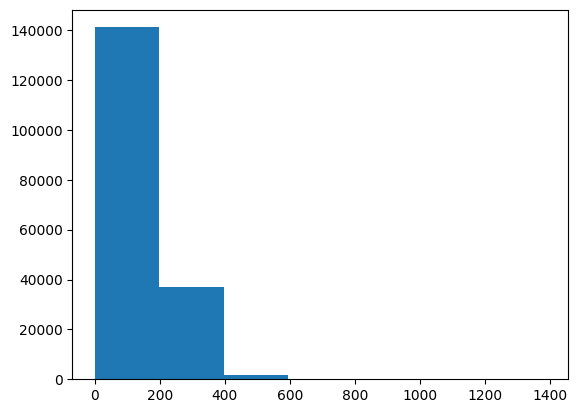

In [86]:
# Check the distribution of our sequences at character-level
plt.hist(char_lens,bins =7);

In [87]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [88]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [89]:
# Create a char-level token vectorizer instance
NUM_CHAR_TOKENS =len(alphabet) + 2
char_vectorizer =TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length =output_seq_char_len,
                                   standardize = "lower_and_strip_punctuation", # Default
                                   name = "char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [90]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least common characters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [91]:
# Test the character tokenizer on the char datasets
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
f i v e   c o n s e c u t i v e   d a y s   o f   a n o d a l   t d c s   o v e r   m @   c o m b i n e d   w i t h   s t a n d a r d   t r e a t m e n t   a p p e a r s   t o   r e d u c e   p a i n   i n t e n s i t y   a n d   m a y   i m p r o v e   p r o m   ,   f a s t e r   t h a n   s t a n d a r d   t r e a t m e n t   a l o n e   .

Length of chars: 145

Vectorized chars:
[[17  4 21  2 11  7  6  9  2 11 16  3  4 21  2 10  5 19  9  7 17  5  6  7
  10  5 12  3 10 11  9  7 21  2  8 15 11  7 15 22  4  6  2 10 20  4  3 13
   9  3  5  6 10  5  8 10  3  8  2  5  3 15  2  6  3  5 14 14  2  5  8  9
   3  7  8  2 10 16 11  2 14  5  4  6  4  6  3  2  6  9  4  3 19  5  6 10
  15  5 19  4 15 14  8  7 21  2 14  8  7 15 17  5  9  3  2  8  3 13  5  6
   9  3  5  6 10  5  8 10  3  8  2  5  3 15  2  6  3  5 12  7  6  2  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0

In [92]:
### Creating a character-level embedding
char_embedding = layers.Embedding(input_dim=28,
                                  output_dim = 25,
                                  mask_zero = False,
                                  name = "Character_embedding"
                                  )

In [93]:
# Test on a random char sentence
random_train_chars = random.choice(train_chars)
print(f'Random char sentence\n{random_train_chars}')
rand_char_vectorized =char_vectorizer(random_train_chars)
print(f"\nVectorize sentence\n{rand_char_vectorized}")
print(f"\nEmbedded sentence\n{char_embedding(rand_char_vectorized)}")
rand_embed =char_embedding(rand_char_vectorized)
print(f"\nEmbedded shape:{rand_embed.shape}")



Random char sentence
t h e   e x p r e s s i o n   o f   t o l l - l i k e   r e c e p t o r - @   (   t l r @   )   ,   n u c l e a r   f a c t o r - k a p p a b   (   n f - k a p p a b   )   ,   a n d   o c c l u d i n   w e r e   d e t e c t e d   .

Vectorize sentence
[ 3 13  2  2 24 14  8  2  9  9  4  7  6  7 17  3  7 12 12 12  4 23  2  8
  2 11  2 14  3  7  8  3 12  8  6 16 11 12  2  5  8 17  5 11  3  7  8 23
  5 14 14  5 22  6 17 23  5 14 14  5 22  5  6 10  7 11 11 12 16 10  4  6
 20  2  8  2 10  2  3  2 11  3  2 10  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers `(char_vectorizer)` as well as numerically represent them as an embedding `(char_embed)` let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.
```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [174]:
inputs = layers.Input(shape=(1,),dtype='string')
char_vectors =char_vectorizer(inputs)
char_embed =char_embedding(char_vectors)
x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(char_embed)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_5 = tf.keras.Model(inputs,outputs)

In [175]:
# Compile model
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [176]:
model_5.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Character_embedding (Embedding) │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Let's change the chars level data to tensorflow dataset
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# We will fit on 50 % of batches to save on time
model_5_history = model_5.fit(train_char_dataset,
                              # steps_per_epoch = int(0.5 * len(train_char_dataset)),
                              epochs=3 ,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.5 * len(val_char_dataset))
                              )

Epoch 1/3
5195/5627 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4750 - loss: 1.2623

In [99]:
# Evaluate model_5 on whole validation char dataset
model_5.evaluate(test_char_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5026 - loss: 1.2052


[1.207090139389038, 0.504529595375061]

In [100]:
# Make predictions with character model only
model_5_pred_probs = model_5.predict(test_char_dataset)
model_5_pred_probs


942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.24921466, 0.21912366, 0.31053054, 0.15367457, 0.06745659],
       [0.16612016, 0.19123901, 0.3795506 , 0.17431863, 0.08877155],
       [0.05916987, 0.08629724, 0.3571633 , 0.02804473, 0.4693249 ],
       ...,
       [0.03059783, 0.05310084, 0.13089383, 0.01358012, 0.77182746],
       [0.07942779, 0.07823309, 0.26741698, 0.02303109, 0.551891  ],
       [0.02011889, 0.04006526, 0.70717293, 0.0219343 , 0.2107087 ]],
      dtype=float32)

In [101]:
# Convert predictions to classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([2, 2, 4, ..., 4, 4, 2])>

In [102]:
# Calculate Conv1D char model results
cnn_char = score_function(test_labels_encoded,model_5_preds)
cnn_char

{'Accuracy_score': 0.5045296167247387,
 'F1-Score': 0.4520187081684004,
 'Recall_Score': 0.5045296167247387,
 'Precision_Score': 0.45727637406606575}

### Model 6: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_5` with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


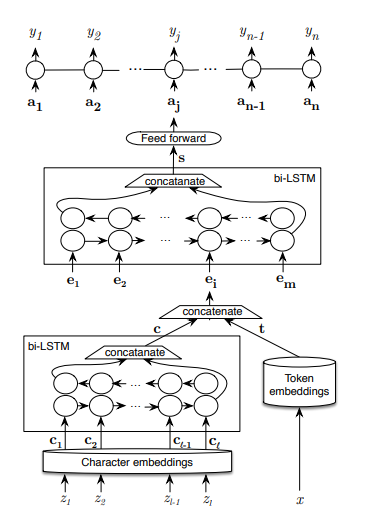

In [168]:
#1. Setup token inputs/model (Using USE)
token_inputs = layers.Input(shape=(512,),dtype=tf.float32,name="token_input_USE")
# token_embeddings = text_vectorizer(token_inputs) # We have already defined our token embedding on model_1
token_output = layers.Dense(128,activation='relu')(token_inputs)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_output)

#2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name ="char_input")
char_vector = char_vectorizer(char_inputs)
char_embeddings=char_embedding(char_vector)

char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs=char_bi_lstm)
#3. Concate token and ch inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name= "token_char_hybrid")([token_model.output,char_model.output])

#4. Create output layers - additin of dropout discussed in the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

model_6 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs = output_layer,
                         name = "model_6_token_and_char_embeddings")


# embedded_sentence

In [169]:
# Compile token char  model
model_6.compile(loss='categorical_crossentropy',
                metrics = ['accuracy'],
                optimizer =  tf.keras.optimizers.Adam())

In [170]:
model_6.summary()

Model: "model_6_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input_USE     │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Character_embedding │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     65,664 │ token_input_USE[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 50)        │     10,200 │ Character_embedd… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 178)       │          0 │ dense_30[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 178)       │          0 │ token_char_hybri… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 200)       │     35,800 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 200)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 5)         │      1,005 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,369 (442.85 KB)

 Trainable params: 113,369 (442.85 KB)

 Non-trainable params: 0 (0.00 B)

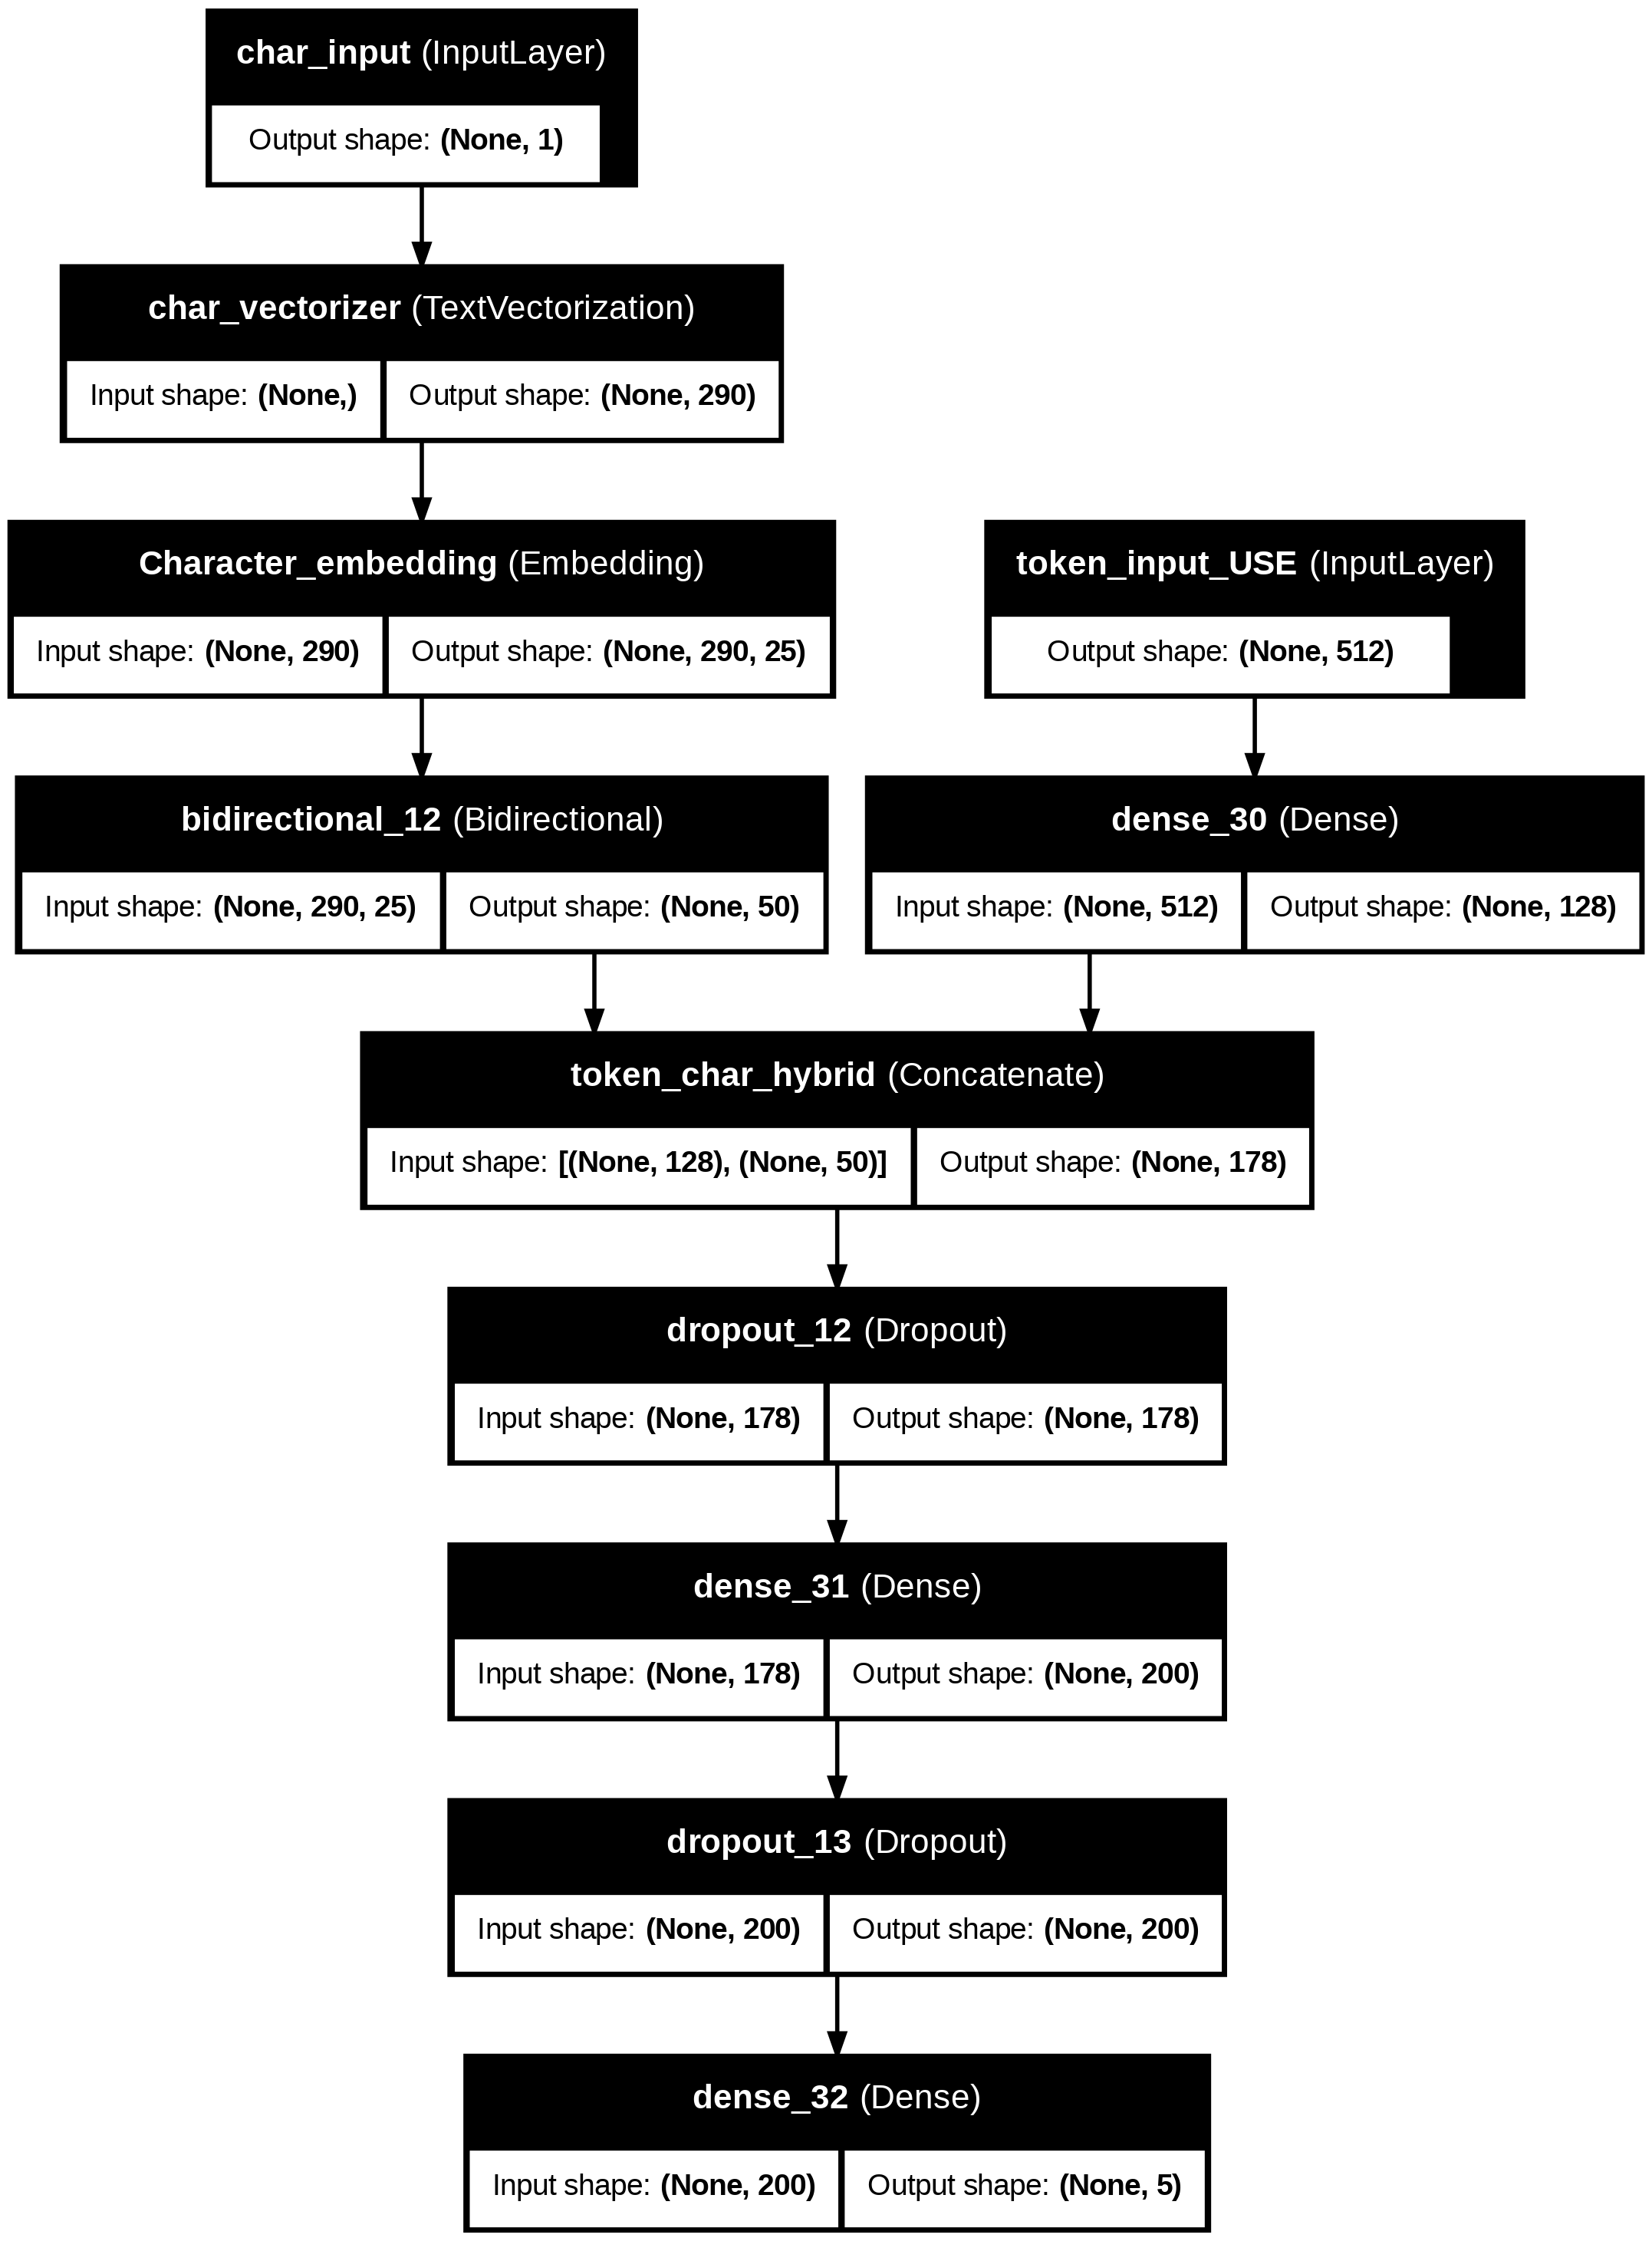

In [171]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_6,show_shapes=True, show_layer_names=True)

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset `with a tuple as it's first input, for example:

* `((token_data, char_data), (label))`

In [ ]:
# Combine char and tokens into a dataset
emb_chr_train =embedded_sentence(train_chars)

train_char_token_data = tf.data.Dataset.from_tensor_slices((emb_chr_train,train_sentences)) # make data
train_char_label_data = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_label_data))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat the same steps validation data
emb_chr_val = embedded_sentence(val_chars)
# emb_chr_val = np.expand_dims(emb_chr_val,axis=1) # add an external dimension to fit model dimension
val_char_token_data = tf.data.Dataset.from_tensor_slices((emb_chr_val,val_sentences))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [158]:
train_char_token_dataset.element_spec,val_char_token_dataset.element_spec

(((TensorSpec(shape=(None, 512), dtype=tf.float32, name=None),
   TensorSpec(shape=(None,), dtype=tf.string, name=None)),
  TensorSpec(shape=(None, 5), dtype=tf.float64, name=None)),
 ((TensorSpec(shape=(None, 512), dtype=tf.float32, name=None),
   TensorSpec(shape=(None,), dtype=tf.string, name=None)),
  TensorSpec(shape=(None, 5), dtype=tf.float64, name=None)))

### Fitting a model on token and character-level sequences

In [173]:
# Fit the model on tokens and char
model_6_history = model_6.fit(train_char_token_dataset,
                              # steps_per_epoch =int(0.3*len(train_char_token_dataset)),
                              epochs =3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.5*len(val_char_token_dataset))
                              )

Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 123s 22ms/step - accuracy: 0.5263 - loss: 1.1387 - val_accuracy: 0.5844 - val_loss: 1.0332
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 123s 22ms/step - accuracy: 0.5666 - loss: 1.0610 - val_accuracy: 0.6074 - val_loss: 0.9870
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 124s 22ms/step - accuracy: 0.5802 - loss: 1.0361 - val_accuracy: 0.6191 - val_loss: 0.9563
